# Group Project: Analyzing MTA Turnstile Data to Increase WYWT Gala Participation
## Jocelyn Lau, Shreyak Vashisht, Roger Wang


## Set Up

In [1]:
import pandas as pd
import calendar
import datetime

import matplotlib.pyplot as plt
# You can configure the format of the images: ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’.
%config InlineBackend.figure_format = 'svg'
# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

# Plot configurations
plt.rc('axes', axisbelow=True)

## Import Data

In [2]:
# Create function to import multiple data files

data_path = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"

def import_data(date):
    """
    import data
    clean column names
    """
    dfname = pd.read_csv(data_path+date+".txt")
    dfname.columns = dfname.columns.str.strip()
    return dfname
          
mta190504_raw = import_data("190504")
mta190511_raw = import_data("190511")
mta190518_raw = import_data("190518")
mta190525_raw = import_data("190525")
mta190601_raw = import_data("190601")


In [3]:
# Concatenate all data
frames = [mta190504_raw, mta190511_raw, mta190518_raw, mta190525_raw, mta190601_raw]

mta19_raw = pd.concat(frames).reset_index().drop(["index"], axis=1)

mta19_raw.info()
mta19_raw.describe()
#mta19_raw.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1026784 entries, 0 to 1026783
Data columns (total 11 columns):
C/A         1026784 non-null object
UNIT        1026784 non-null object
SCP         1026784 non-null object
STATION     1026784 non-null object
LINENAME    1026784 non-null object
DIVISION    1026784 non-null object
DATE        1026784 non-null object
TIME        1026784 non-null object
DESC        1026784 non-null object
ENTRIES     1026784 non-null int64
EXITS       1026784 non-null int64
dtypes: int64(2), object(9)
memory usage: 86.2+ MB


,ENTRIES,EXITS
count,1.026784e+06,1.026784e+06
mean,4.154868e+07,3.402282e+07
std,2.116724e+08,1.949751e+08
min,0.000000e+00,0.000000e+00
25%,3.525555e+05,1.442150e+05
50%,2.174353e+06,1.245738e+06
75%,6.789071e+06,4.603742e+06
max,2.129343e+09,2.124127e+09


In [4]:
def time_interval(x):
    if x in [0,1,2,3]:
        return "8:00PM-11:59PM"
    elif x in [4,5,6,7]:
        return "0:00AM-3:59AM"
    elif x in [8,9,10,11]:
        return "4:00AM-7:59AM"
    elif x in [12,13,14,15]:
        return "8:00AM-11:59AM"
    elif x in [16,17,18,19]:
        return "12:00PM-3:59PM"
    elif x in [20,21,22,23]:
        return "4:00PM-7:59PM"

In [5]:
# Add and format new variables

def data_clean(dfname):
    """
    add and format new variables
    """
    dfname2 = dfname.copy()
    # Create variables:
    # "time_hour" that simplifies the hour for later grouping purposes
    dfname2["time_hour"] = pd.to_numeric(dfname2["TIME"].str[0:2])
    # formatted date variable "DDATE"
    dfname2['DDATE']=[datetime.datetime.strptime(x, '%m/%d/%Y') for x in dfname2['DATE']]
    # formatted time variable "DTIME"
    dfname2['DTIME']=[datetime.datetime.strptime(x, '%H:%M:%S') for x in dfname2['TIME']]
    dfname2['DTIME']=[format(x,"%H:%M:%S") for x in dfname2['DTIME']]
    # formatted combined date and time variable "DATETIME"
    dfname2['DDATETIME'] = pd.to_datetime(dfname2['DATE']+" "+dfname2['TIME'])
    # formatted day of the week variable "DDAY"
    dfname2['DDAY']=[calendar.day_name[datetime.datetime.weekday(x)] for x in dfname2['DDATE']]
    # create time period category "time_cat"
    dfname2["time_cat"] = dfname2["time_hour"].apply(time_interval)
    
    # Sort before grouping for difference calculating
    dfname2.sort_values(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION","DATE","TIME","DESC"], inplace = True)
    # Create difference columns to calculate difference in entries and exits between the row and the row before (aka the time before)
    dfname2["entries_diff"] = dfname2.groupby(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION"]).ENTRIES.diff()
    dfname2["exits_diff"] = dfname2.groupby(["C/A","UNIT","SCP","STATION","LINENAME","DIVISION"]).EXITS.diff()
    dfname2["entries-exits"] = dfname2["entries_diff"] - dfname2["exits_diff"]
    dfname2["entries+exits"] = dfname2["entries_diff"] + dfname2["exits_diff"]
        
    #keep only rows with positive entries_diff, exits_diff, and ENTRIES
    dfname2= dfname2[dfname2.entries_diff > 0]
    dfname2 = dfname2[dfname2.exits_diff > 0]
    dfname2 = dfname2[dfname2.ENTRIES > 0]
    # dropping turnstile 00-04-00 at 23rd st due to data anomaly
    dfname2 = dfname2[(dfname2["STATION"] != "TWENTY THIRD ST") & (dfname2["SCP"] != "00-04-00")]
    # exclude high entries and exits that are likely a result of a terminal reset
    dfname2 = dfname2[dfname2.entries_diff < 100000]
    dfname2 = dfname2[dfname2.exits_diff < 100000].reset_index().drop(["index"],axis=1)
    dfname2.drop([412758,412902,413046,413190,413334], inplace=True)
    return dfname2

mta19 = data_clean(mta19_raw)

In [6]:
# mta19.info()
# mta19.head(10)

In [7]:
# mta19.describe()

## Graph Data

In [8]:
# Group by station, day of week, and date
mta_station_day = mta19.groupby(["STATION","DDAY","DDATE"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].sum().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day.head(10)

,STATION,DDAY,DDATE,entries_diff,exits_diff,entries+exits,entries-exits
13021,ZEREGA AV,Wednesday,2019-05-08,2931.0,2731.0,5662.0,200.0
13011,ZEREGA AV,Thursday,2019-05-09,2994.0,2625.0,5619.0,369.0
13020,ZEREGA AV,Wednesday,2019-05-01,2900.0,2700.0,5600.0,200.0
13023,ZEREGA AV,Wednesday,2019-05-22,2872.0,2700.0,5572.0,172.0
13024,ZEREGA AV,Wednesday,2019-05-29,2824.0,2736.0,5560.0,88.0
13014,ZEREGA AV,Thursday,2019-05-30,2829.0,2702.0,5531.0,127.0
13010,ZEREGA AV,Thursday,2019-05-02,2917.0,2582.0,5499.0,335.0
13016,ZEREGA AV,Tuesday,2019-05-07,2841.0,2640.0,5481.0,201.0
13017,ZEREGA AV,Tuesday,2019-05-14,2830.0,2639.0,5469.0,191.0
13018,ZEREGA AV,Tuesday,2019-05-21,2856.0,2611.0,5467.0,245.0


In [9]:
mta_station_dayavg = mta_station_day.groupby(["STATION"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["entries+exits"], ascending=[True])
mta_station_dayavg.tail(10)

,STATION,entries_diff,exits_diff,entries+exits,entries-exits
9,125 ST,66059.600000,56150.828571,122210.428571,9908.771429
110,86 ST,71457.914286,66353.828571,137811.742857,5104.085714
68,42 ST-PORT AUTH,80904.657143,69442.142857,150346.800000,11462.514286
225,FULTON ST,82502.371429,68961.314286,151463.685714,13541.057143
46,23 ST,96964.571429,69301.628571,166266.200000,27662.942857
352,TIMES SQ-42 ST,87412.314286,81899.057143,169311.371429,5513.257143
14,14 ST-UNION SQ,91151.800000,84337.457143,175489.257143,6814.342857
59,34 ST-HERALD SQ,100804.514286,95162.742857,195967.257143,5641.771429
232,GRD CNTRL-42 ST,124465.600000,107245.828571,231711.428571,17219.771429
61,34 ST-PENN STA,144831.428571,132091.971429,276923.400000,12739.457143


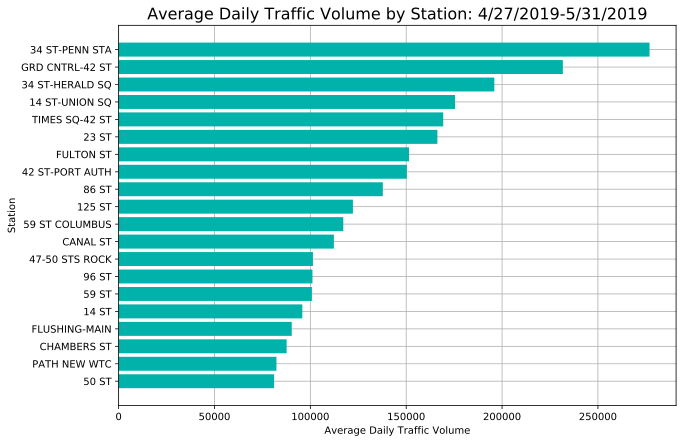

In [22]:
# GRAPH 1
#Plot graph of total volume
plt.figure(figsize = [10,7])
plt.barh(mta_station_dayavg["STATION"][-20:],mta_station_dayavg["entries+exits"][-20:],color= '#00b2a9')
plt.grid()
plt.title("Average Daily Traffic Volume by Station: 4/27/2019-5/31/2019", fontsize = 16)
plt.ylabel("Station")
plt.xlabel("Average Daily Traffic Volume");
plt.savefig("graph1.png", bbox_inches = 'tight')


In [11]:
# Create sorting variables:

def day_sort(x):
    """
    create ordered variable to sort data for graph axes by day of the week
    """
    if x == "Sunday":
        return 1
    elif x == "Monday":
        return 2
    elif x == "Tuesday":
        return 3
    elif x == "Wednesday":
        return 4
    elif x == "Thursday":
        return 5
    elif x == "Friday":
        return 6
    elif x == "Saturday":
        return 7
    
def time_sort(x):
    """
    create ordered variable to sort data for graph axes by time variable
    """
    if x == "0:00AM-3:59AM":
        return 1
    elif x == "4:00AM-7:59AM":
        return 2
    elif x == "8:00AM-11:59AM":
        return 3
    elif x == "12:00PM-3:59PM":
        return 4
    elif x == "4:00PM-7:59PM":
        return 5
    elif x == "8:00PM-11:59PM":
        return 6


In [12]:
#GRAPH 2
mta_station_weekdayavg = mta_station_day.groupby(["STATION","DDAY"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["entries+exits"], ascending=[True])

mta_station_weekdayavg["day_sort"] = mta_station_weekdayavg["DDAY"].apply(day_sort)

mta_station_weekdayavg.head(10)

,STATION,DDAY,entries_diff,exits_diff,entries+exits,entries-exits,day_sort
2160,ORCHARD BEACH,Wednesday,1.000000,1.000000,2.000000,0.000000,4
2159,ORCHARD BEACH,Thursday,1.000000,2.000000,3.000000,-1.000000,5
2156,ORCHARD BEACH,Monday,1.000000,2.000000,3.000000,-1.000000,2
2158,ORCHARD BEACH,Sunday,10.000000,25.000000,35.000000,-15.000000,1
2403,ST. GEORGE,Thursday,33.500000,3.000000,36.500000,30.500000,5
2157,ORCHARD BEACH,Saturday,18.000000,24.000000,42.000000,-6.000000,7
2404,ST. GEORGE,Tuesday,42.000000,4.000000,46.000000,38.000000,3
2401,ST. GEORGE,Saturday,44.000000,2.750000,46.750000,41.250000,7
2400,ST. GEORGE,Monday,64.000000,3.666667,67.666667,60.333333,2
2402,ST. GEORGE,Sunday,71.333333,4.333333,75.666667,67.000000,1


In [13]:
mta_34PE= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='34 ST-PENN STA' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_GC42= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='GRD CNTRL-42 ST' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_34HE= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='34 ST-HERALD SQ' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_14UN= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='14 ST-UNION SQ' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)
mta_42TS= mta_station_weekdayavg[mta_station_weekdayavg['STATION'] =='TIMES SQ-42 ST' ].sort_values(['day_sort','DDAY', "entries+exits"], ascending=True)

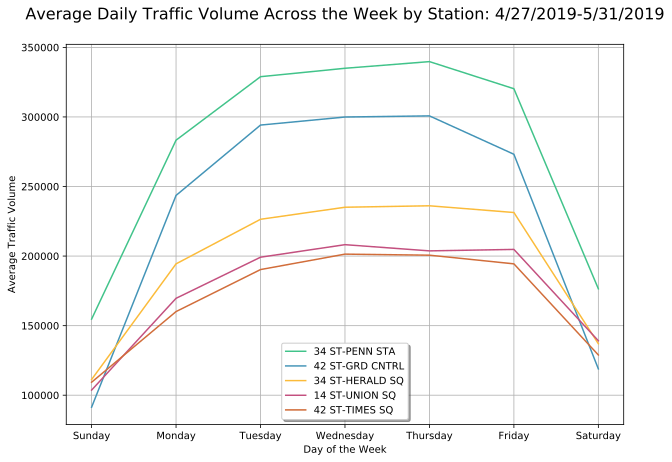

In [23]:
#figure canNOT be the (sum per day)/#time entries because the number time entries  taken per day is not the same
#therefore to inform on the traffic in the week, need to use full volume per day
#seems the WEDNESDAY is the most busy day in general
plt.figure(figsize = [10,7])
plt.grid()
plt.plot(mta_34PE['DDAY'],mta_34PE['entries+exits'],color="#41c38a")
plt.plot(mta_GC42['DDAY'],mta_GC42['entries+exits'],color="#4394b7")
plt.plot(mta_34HE['DDAY'],mta_34HE['entries+exits'],color="#fbbb3a")
plt.plot(mta_14UN['DDAY'],mta_14UN['entries+exits'],color="#c3507f")
plt.plot(mta_42TS['DDAY'],mta_42TS['entries+exits'],color="#d16d3a")
plt.legend(["34 ST-PENN STA","42 ST-GRD CNTRL","34 ST-HERALD SQ","14 ST-UNION SQ","42 ST-TIMES SQ"], shadow = True)
plt.title("Average Daily Traffic Volume Across the Week by Station: 4/27/2019-5/31/2019", fontsize = 16, y = 1.05)
plt.ylabel("Average Traffic Volume")
plt.xlabel("Day of the Week")
plt.savefig("graph2.png", bbox_inches = 'tight');

In [16]:
# Group by station, day of week, date, time_cat
mta_station_day_time = mta19.groupby(["STATION","DDAY","DDATE","time_cat"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].sum().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day_time.head(10)

,STATION,DDAY,DDATE,time_cat,entries_diff,exits_diff,entries+exits,entries-exits
76937,ZEREGA AV,Wednesday,2019-05-08,4:00AM-7:59AM,1272.0,553.0,1825.0,719.0
76931,ZEREGA AV,Wednesday,2019-05-01,4:00AM-7:59AM,1274.0,532.0,1806.0,742.0
76949,ZEREGA AV,Wednesday,2019-05-22,4:00AM-7:59AM,1271.0,520.0,1791.0,751.0
76877,ZEREGA AV,Thursday,2019-05-09,4:00AM-7:59AM,1269.0,516.0,1785.0,753.0
76788,ZEREGA AV,Monday,2019-05-06,4:00AM-7:59AM,1247.0,529.0,1776.0,718.0
76782,ZEREGA AV,Monday,2019-04-29,4:00AM-7:59AM,1243.0,524.0,1767.0,719.0
76919,ZEREGA AV,Tuesday,2019-05-21,4:00AM-7:59AM,1254.0,513.0,1767.0,741.0
76883,ZEREGA AV,Thursday,2019-05-16,4:00AM-7:59AM,1233.0,524.0,1757.0,709.0
76907,ZEREGA AV,Tuesday,2019-05-07,4:00AM-7:59AM,1244.0,511.0,1755.0,733.0
76871,ZEREGA AV,Thursday,2019-05-02,4:00AM-7:59AM,1264.0,481.0,1745.0,783.0


In [17]:
mta_station_day_timeavg = mta_station_day_time.groupby(["STATION","DDAY","time_cat"], as_index=False)[["entries_diff","exits_diff","entries+exits","entries-exits"]].mean().sort_values(["STATION","entries+exits"], ascending=False)
mta_station_day_timeavg.head(10)

,STATION,DDAY,time_cat,entries_diff,exits_diff,entries+exits,entries-exits
15724,ZEREGA AV,Wednesday,4:00AM-7:59AM,1249.8,523.0,1772.8,726.8
15712,ZEREGA AV,Thursday,4:00AM-7:59AM,1233.6,510.2,1743.8,723.4
15718,ZEREGA AV,Tuesday,4:00AM-7:59AM,1220.6,509.8,1730.4,710.8
15688,ZEREGA AV,Friday,4:00AM-7:59AM,1115.8,465.8,1581.6,650.0
15694,ZEREGA AV,Monday,4:00AM-7:59AM,1026.4,425.4,1451.8,601.0
15717,ZEREGA AV,Tuesday,12:00PM-3:59PM,620.8,635.8,1256.6,-15.0
15723,ZEREGA AV,Wednesday,12:00PM-3:59PM,576.4,667.2,1243.6,-90.8
15711,ZEREGA AV,Thursday,12:00PM-3:59PM,600.2,636.0,1236.2,-35.8
15687,ZEREGA AV,Friday,12:00PM-3:59PM,564.0,640.6,1204.6,-76.6
15725,ZEREGA AV,Wednesday,4:00PM-7:59PM,343.8,828.6,1172.4,-484.8


In [18]:
def select_station(station):
    """
    select data for each station and calculate average volume by time period across all days of the week
    """
    new_data = mta_station_day_timeavg[(mta_station_day_timeavg["STATION"] == station) & (mta_station_day_timeavg["DDAY"] == "Wednesday")].sort_values(["DDAY","time_cat","entries+exits"])
    new_data["time_sort"] = new_data["time_cat"].apply(time_sort)
    new_data.sort_values(["DDAY","time_sort"],inplace=True)    
    return new_data

mta_34PE_time_Wed = select_station("34 ST-PENN STA")
mta_GC42_time_Wed = select_station("GRD CNTRL-42 ST")
mta_34HE_time_Wed = select_station("34 ST-HERALD SQ")
mta_14UN_time_Wed = select_station("14 ST-UNION SQ")
mta_42TS_time_Wed = select_station("TIMES SQ-42 ST")

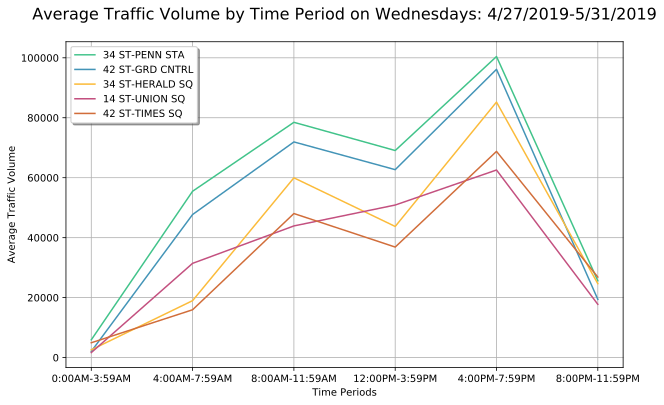

In [26]:
plt.figure(figsize = [10,6])
plt.grid()
plt.plot(mta_34PE_time_Wed['time_cat'],mta_34PE_time_Wed['entries+exits'],color="#41c38a")
plt.plot(mta_GC42_time_Wed['time_cat'],mta_GC42_time_Wed['entries+exits'],color="#4394b7")
plt.plot(mta_34HE_time_Wed['time_cat'],mta_34HE_time_Wed['entries+exits'],color="#fbbb3a")
plt.plot(mta_14UN_time_Wed['time_cat'],mta_14UN_time_Wed['entries+exits'],color="#c3507f")
plt.plot(mta_42TS_time_Wed['time_cat'],mta_42TS_time_Wed['entries+exits'],color="#d16d3a")
plt.title("Average Traffic Volume by Time Period on Wednesdays: 4/27/2019-5/31/2019", fontsize = 16, y = 1.05)
plt.legend(["34 ST-PENN STA","42 ST-GRD CNTRL","34 ST-HERALD SQ","14 ST-UNION SQ","42 ST-TIMES SQ"], shadow = True)
plt.ylabel("Average Traffic Volume")
plt.xlabel("Time Periods")
plt.savefig("graph3.png", bbox_inches = 'tight');

## Graphs

In [20]:
#Graphs stratifying volume by day of the week and time interval

def select_station2(station):
    """
    select data for each station and calculate average volume by time interval and day of the week
    """
    new_data = mta19.groupby(['STATION','DDAY','time_cat'],as_index=False)['entries+exits'].mean()
    new_data = new_data.loc[new_data["STATION"] == station]
    new_data["time_sort"] = new_data["time_cat"].apply(time_sort)
    new_data.sort_values(["DDAY","time_sort"],inplace=True)
    return new_data

mta_GC42_3 = select_station2("GRD CNTRL-42 ST")
mta_34PE_3 = select_station2("34 ST-PENN STA")
mta_34HE_3 = select_station2("34 ST-HERALD SQ")
mta_14UN_3 = select_station2("14 ST-UNION SQ")
mta_42TS_3 = select_station2("TIMES SQ-42 ST")

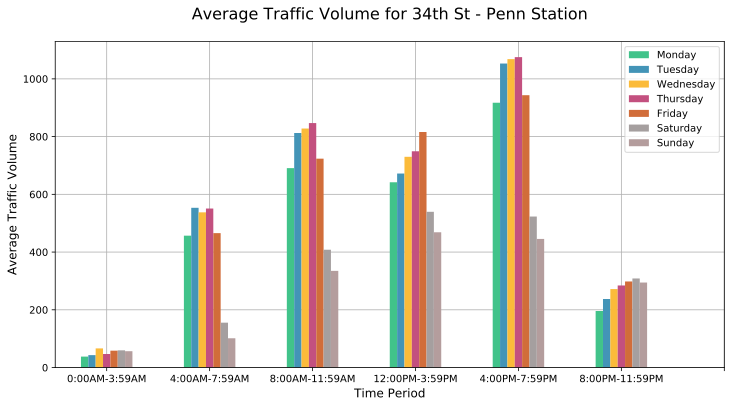

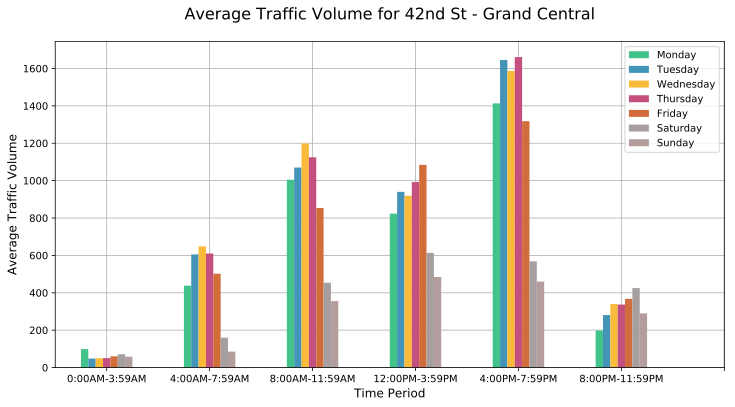

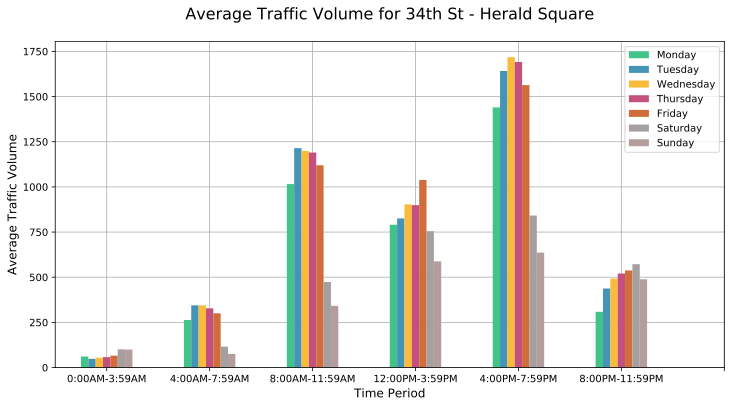

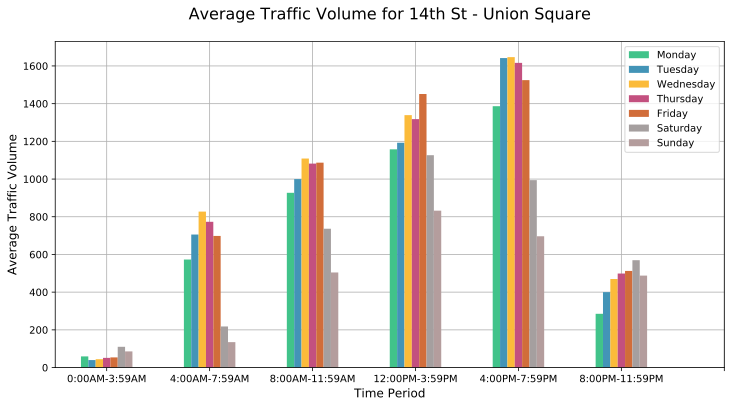

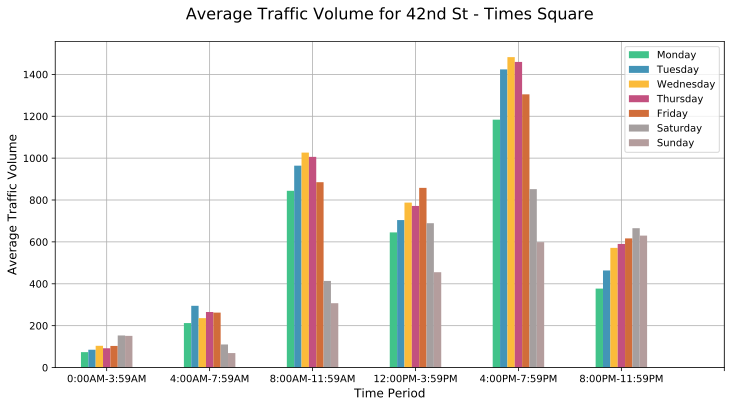

In [21]:
def graph_convert(D1,Station,graphname):
    """
    reshape graph data for each station into format for a grouped bar chart
    plot grouped graph data
    """
    day_dict = {}

    days = D1['DDAY'].unique()
    for day in days:
        day_dict[day] =  D1[D1['DDAY'] == day]['entries+exits'].values

    times = D1['time_cat'].unique()


    Final_df = pd.DataFrame({'time':times, 'Monday':day_dict['Monday'], 
                                'Tuesday':day_dict['Tuesday'], 
                                'Wednesday':day_dict['Wednesday'],'Thursday':day_dict['Thursday'],'Friday':day_dict['Friday'],'Saturday':day_dict['Saturday'],'Sunday':day_dict['Sunday']})
    Final_df
    Final_df[['time', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday',
           'Sunday']].plot(kind='bar', 
                           color= ["#41c38a","#4394b7","#fbbb3a","#c3507f","#d16d3a","#a59f9f","#b49d9d"],
                          figsize = (12,6))
    plt.xlabel('Time Period', fontsize=12);
    plt.ylabel('Average Traffic Volume',fontsize=12)
    plt.grid()
    plt.title("Average Traffic Volume for "+Station, fontsize=16, y = 1.05)
    plt.xticks([i for i in range(Final_df.shape[1]-1)], labels = Final_df['time'], rotation = 0);

    plt.savefig(graphname, bbox_inches = 'tight')
    return 

graph_convert(mta_34PE_3,"34th St - Penn Station","graph4_34PE.png")
graph_convert(mta_GC42_3,"42nd St - Grand Central","graph4_GC42.png")
graph_convert(mta_34HE_3,"34th St - Herald Square","graph4_34HE.png")
graph_convert(mta_14UN_3,"14th St - Union Square","graph4_14UN.png")
graph_convert(mta_42TS_3,"42nd St - Times Square","graph4_42TS.png")